# House Plant classification using ResNet-34

In [40]:
import os
import zipfile
import shutil
import random
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from typing import Dict, List
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader
from torch.optim.sgd import SGD
from torch.optim.optimizer import Optimizer
from torch.nn import CrossEntropyLoss
from torch import nn


# 0. Install and Import libs

In [2]:
!pip install torchmetrics

In [3]:
! pip install torchsummary

In [4]:
from torchsummary import summary
import torchmetrics

# 1. Exploring the data and create dataset objects

## 1.1 Getting the data



In [5]:
data_path = '/kaggle/working/data'
original_path = '/kaggle/working/house_plant_species'

In [6]:
!kaggle datasets download -d kacpergregorowicz/house-plant-species

Dataset URL: https://www.kaggle.com/datasets/kacpergregorowicz/house-plant-species
License(s): CC-BY-NC-SA-4.0
100%|█████████████████████████████████████▉| 4.84G/4.85G [03:39<00:00, 27.7MB/s]
100%|██████████████████████████████████████| 4.85G/4.85G [03:39<00:00, 23.7MB/s]


In [7]:
# Extract dataset
with zipfile.ZipFile('/kaggle/working/house-plant-species.zip', 'r') as file_zip:
    file_zip.extractall()

## 1.2 Exploration

In [8]:
def show_random_species(original_path: str ) -> None:
  plt.figure(figsize=(12, 12))
  for i in range(9):
    specie = random.sample(os.listdir(original_path), k=1)[0]
    image_path = random.sample(os.listdir(f'{original_path}/{specie}'), k=1)[0]

    plt.subplot(3, 3, i+1)
    image = plt.imread(f'{original_path}/{specie}/{image_path}')
    plt.title(specie)
    plt.axis(False)
    plt.imshow(image)

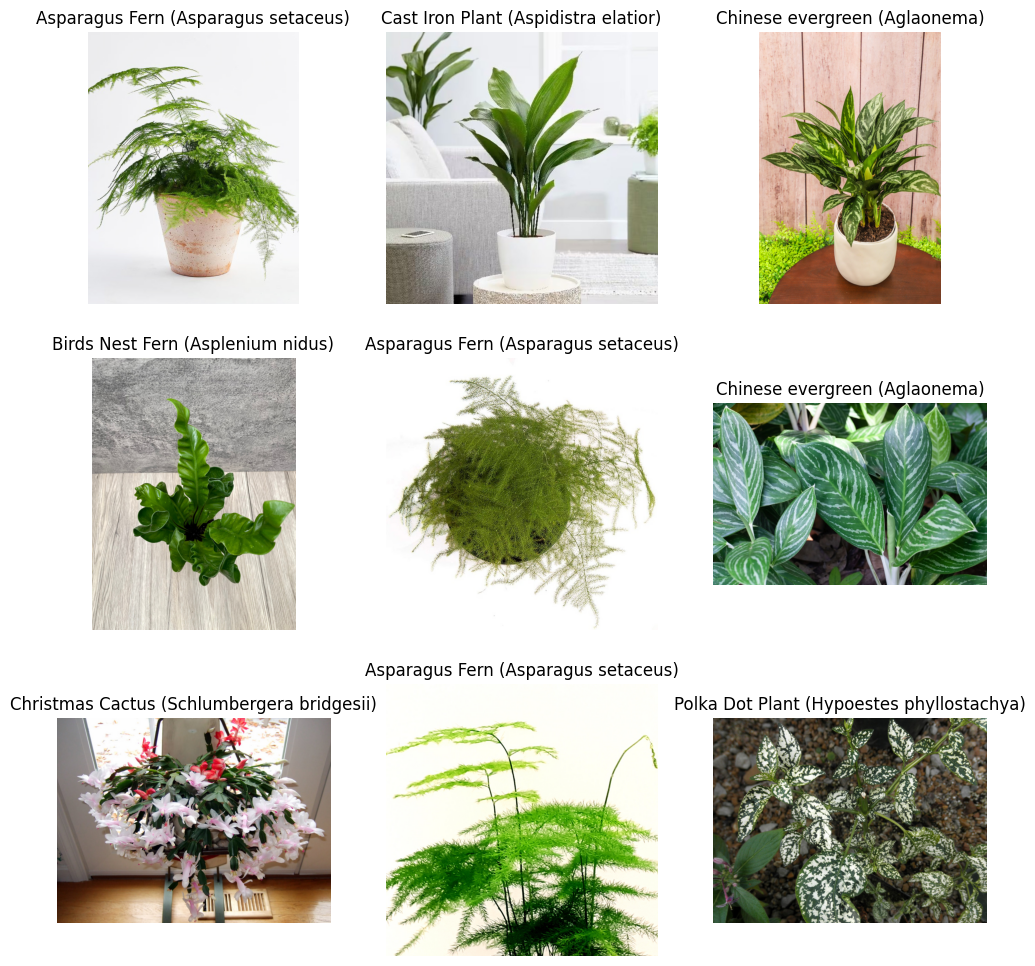

In [9]:
show_random_species(original_path)

In [10]:
species_df = pd.DataFrame(columns=['species', 'qty'])
species_df['species'] = os.listdir(original_path)
species_df['qty'] = [len(os.listdir(f"{original_path}/{specie}")) for specie in os.listdir(original_path)]

In [11]:
species_df[:10]

,species,qty
0,Asparagus Fern (Asparagus setaceus),169
1,Snake plant (Sanseviera),396
2,ZZ Plant (Zamioculcas zamiifolia),438
3,Ponytail Palm (Beaucarnea recurvata),197
4,Ctenanthe,347
5,Jade plant (Crassula ovata),353
6,Birds Nest Fern (Asplenium nidus),290
7,Pothos (Ivy arum),243
8,Rattlesnake Plant (Calathea lancifolia),316
9,Calathea,330


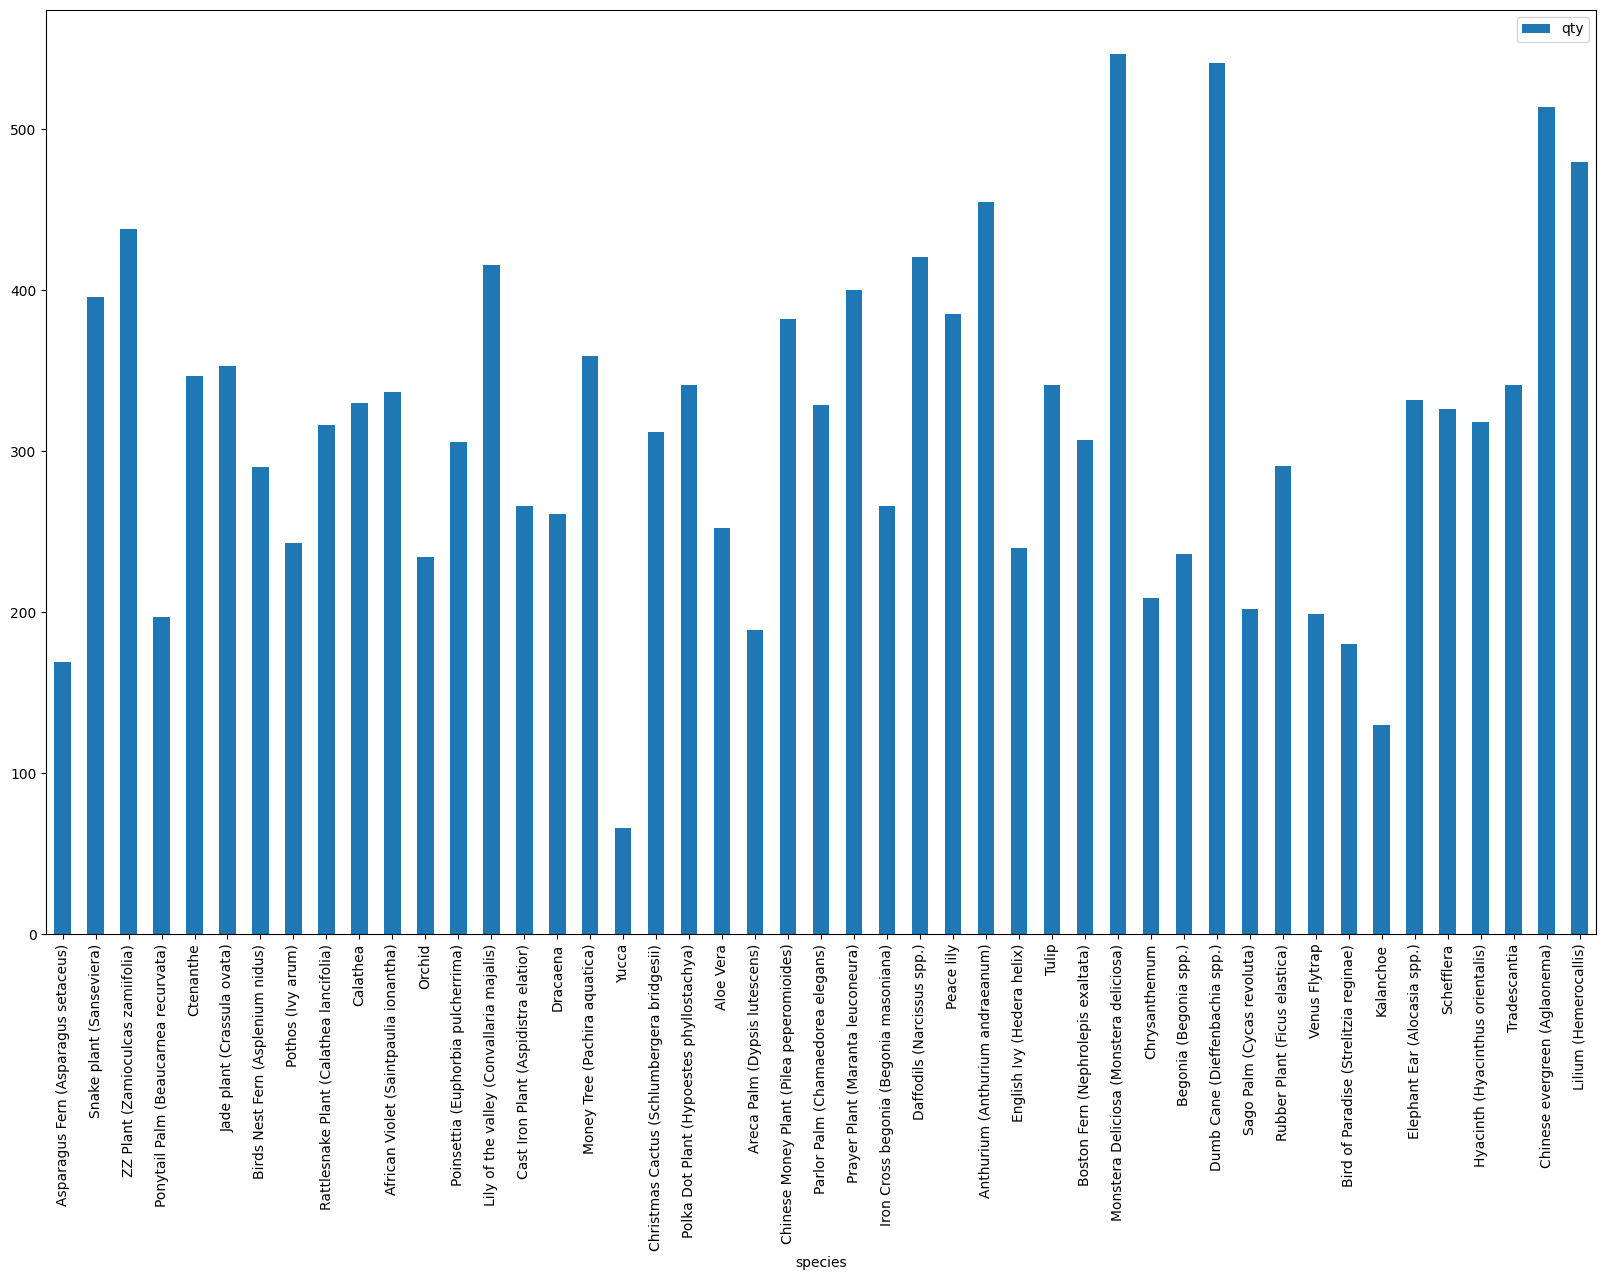

In [12]:
species_df.plot(kind='bar', x='species', y='qty', figsize=(20, 12));

## 1.3 Formating folder structures to standart classification format
- /imagens
    - /train
      - /class1
      - /class2
      - /...
    - /validation
      - /class1
      - /class2
      - /...
    - /test
      - /class1
      - /class2
      - /...


Sampling will be done using python random.samples

In [13]:
# Returns a simple version of specie name
def get_specie_name(specie: str) -> str:
  specie_name = specie.split('(')[0].lower().replace(' ', '_')
  return specie_name[:len(specie_name)-1] if specie_name[-1] == '_' else specie_name


def create_dataset_folders(new_path: str, original_path: str) -> None:
  species = os.listdir(original_path)

  # General folders
  os.makedirs(f'{new_path}/train', exist_ok=True)
  os.makedirs(f'{new_path}/test', exist_ok=True)

  # Create folders for each specie
  for dataset in os.listdir(new_path):
      for specie in species:
        os.makedirs(f'{new_path}/{dataset}/{get_specie_name(specie)}', exist_ok=True)

# Random sampling for each catgory and retunrna dict with classes as key
# and test images as value
def get_test_images(path: str, test_size: float) -> Dict[str, str]:
  test_images = {}
  for specie in os.listdir(path):
    qty = len(os.listdir(f'{path}/{specie}'))
    test_qty = int(qty * test_size)
    print(f'{specie}: {qty}, {test_qty}')
    test_samples = random.sample(os.listdir(f'{path}/{specie}'), test_qty)
    test_images[specie] = test_samples

  return test_images

# Move test and train images to respective folders
def move_images(test_images: dict, original_path: str, new_path: str) -> None:

  # Move images test to test folder
  for specie, images in test_images.items():
    for image in images:
      shutil.copy(f'{original_path}/{specie}/{image}', f'{new_path}/test/{get_specie_name(specie)}')

  # Move the rest os images to train folder
  for specie in os.listdir(original_path):
    for image in os.listdir(f'{original_path}/{specie}'):
      shutil.copy(f'{original_path}/{specie}/{image}', f'{new_path}/train/{get_specie_name(specie)}')



In [14]:
create_dataset_folders(new_path=data_path, original_path=original_path)

test_images = get_test_images(path=original_path, test_size=0.2)

move_images(test_images=test_images,
            original_path=original_path,
            new_path=data_path)



Asparagus Fern (Asparagus setaceus): 169, 33
Snake plant (Sanseviera): 396, 79
ZZ Plant (Zamioculcas zamiifolia): 438, 87
Ponytail Palm (Beaucarnea recurvata): 197, 39
Ctenanthe: 347, 69
Jade plant (Crassula ovata): 353, 70
Birds Nest Fern (Asplenium nidus): 290, 58
Pothos (Ivy arum): 243, 48
Rattlesnake Plant (Calathea lancifolia): 316, 63
Calathea: 330, 66
African Violet (Saintpaulia ionantha): 337, 67
Orchid: 234, 46
Poinsettia (Euphorbia pulcherrima): 306, 61
Lily of the valley (Convallaria majalis): 416, 83
Cast Iron Plant (Aspidistra elatior): 266, 53
Dracaena: 261, 52
Money Tree (Pachira aquatica): 359, 71
Yucca: 66, 13
Christmas Cactus (Schlumbergera bridgesii): 312, 62
Polka Dot Plant (Hypoestes phyllostachya): 341, 68
Aloe Vera: 252, 50
Areca Palm (Dypsis lutescens): 189, 37
Chinese Money Plant (Pilea peperomioides): 382, 76
Parlor Palm (Chamaedorea elegans): 329, 65
Prayer Plant (Maranta leuconeura): 400, 80
Iron Cross begonia (Begonia masoniana): 266, 53
Daffodils (Narcissu

## 1.4 Dataset objects

In [15]:
# Set the project seed
torch.manual_seed(42)

# Transforms the images with some data augmentation on train data
train_transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomVerticalFlip(0.5),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomRotation(0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Basic transforms on the test data
test_transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

> 🔔 [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html#imagefolder)

Folders structure
- root/dog/xxx.png
- root/dog/xxy.png
- root/dog/[...]/xxz.png
---
- root/cat/123.png
- root/cat/nsdf3.png
- root/cat/[...]/asd932_.png

In [16]:
train_dataset = ImageFolder(root=f'{data_path}/train',
                            transform=train_transformer)

test_dataset = ImageFolder(root=f'{data_path}/test',
                           transform=test_transformer)

In [17]:
train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 14774
     Root location: /kaggle/working/data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 2939
     Root location: /kaggle/working/data/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [83]:
test_dataset.class_to_idx

{'african_violet': 0,
 'aloe_vera': 1,
 'anthurium': 2,
 'areca_palm': 3,
 'asparagus_fern': 4,
 'begonia': 5,
 'bird_of_paradise': 6,
 'birds_nest_fern': 7,
 'boston_fern': 8,
 'calathea': 9,
 'cast_iron_plant': 10,
 'chinese_evergreen': 11,
 'chinese_money_plant': 12,
 'christmas_cactus': 13,
 'chrysanthemum': 14,
 'ctenanthe': 15,
 'daffodils': 16,
 'dracaena': 17,
 'dumb_cane': 18,
 'elephant_ear': 19,
 'english_ivy': 20,
 'hyacinth': 21,
 'iron_cross_begonia': 22,
 'jade_plant': 23,
 'kalanchoe': 24,
 'lilium': 25,
 'lily_of_the_valley': 26,
 'money_tree': 27,
 'monstera_deliciosa': 28,
 'orchid': 29,
 'parlor_palm': 30,
 'peace_lily': 31,
 'poinsettia': 32,
 'polka_dot_plant': 33,
 'ponytail_palm': 34,
 'pothos': 35,
 'prayer_plant': 36,
 'rattlesnake_plant': 37,
 'rubber_plant': 38,
 'sago_palm': 39,
 'schefflera': 40,
 'snake_plant': 41,
 'tradescantia': 42,
 'tulip': 43,
 'venus_flytrap': 44,
 'yucca': 45,
 'zz_plant': 46}

In [18]:
# (image, categorie)
train_dataset[0][0].shape, train_dataset[0][0].dtype, train_dataset[0]

(torch.Size([3, 224, 224]),
 torch.float32,
 (tensor([[[ 1.8208,  1.8037,  1.8722,  ...,  1.5468,  1.3413,  1.0331],
           [ 1.8379,  1.9407,  1.9235,  ...,  1.7865,  1.5982,  1.3070],
           [ 1.8550,  1.9407,  1.8379,  ...,  1.8722,  1.7865,  1.5639],
           ...,
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008]],
  
          [[ 1.9034,  1.9209,  2.0084,  ...,  1.6933,  1.4482,  1.0805],
           [ 1.9209,  2.0609,  2.0434,  ...,  1.9384,  1.7283,  1.4307],
           [ 1.9909,  2.0434,  1.9384,  ...,  2.0084,  1.9034,  1.6758],
           ...,
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182]],
  
          [[ 2.0648,  2.1346,  2.2217,  

## 1.5 Data Loaders

> 🔔 **Differences between Dataset classes and DataLoaders**:

In [19]:
# Convert ImageFolder objects in to DataLoaders
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=128,
                              num_workers=2,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             num_workers=2,
                             batch_size=128,
                             shuffle=False)

## 1.6 Set Device


In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using {device} device')

Using cuda device


# 2. ResNet34 import vs ResNet34 from scratch

> Paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385)

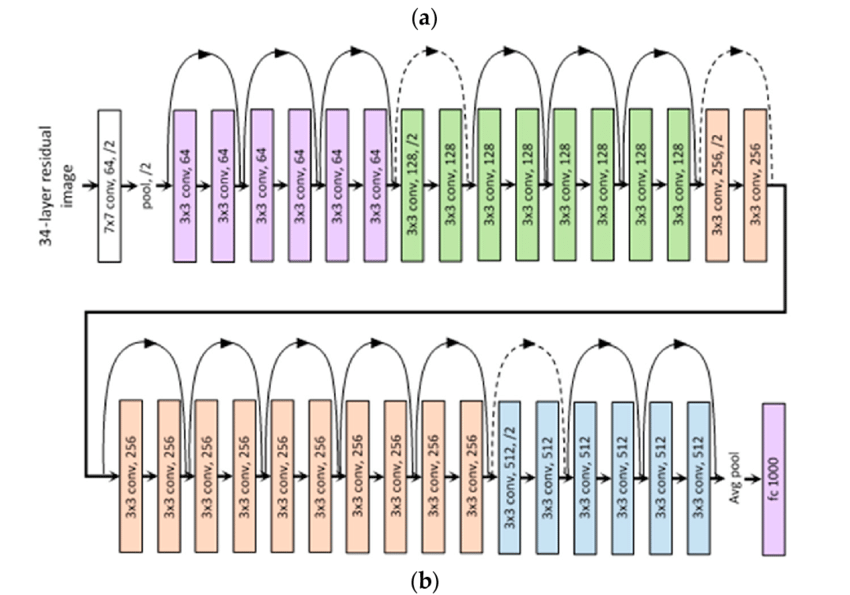

## 2.1 Import Resnet34

In [21]:
imported_resnet34 = models.resnet34(weights=None)

In [22]:
summary(imported_resnet34.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## 2.2 ResNet34 from scratch



### 2.3 Residual Blocks

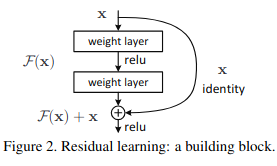 | 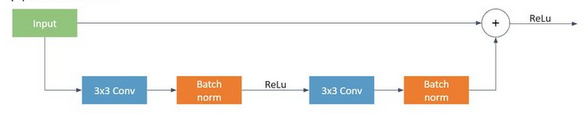

In [23]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, stride=1, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Using padding to identity mapping
        if stride == 1:
          self.conv_block1 = nn.Sequential(
              nn.Conv2d(in_features, out_features, kernel_size=3, stride=stride, padding='same', bias=False),
              nn.BatchNorm2d(out_features),
              nn.ReLU()
          )
        else: # stride with no padding when necessary
          self.conv_block1 = nn.Sequential(
              nn.Conv2d(in_features, out_features, kernel_size=3, padding=1, stride=stride, bias=False),
              nn.BatchNorm2d(out_features),
              nn.ReLU()
          )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(out_features, out_features, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_features),
        )

        # Using 1x1 convolution to project shotcuts when shapes are mismatching
        self.projection = None
        if stride != 1 or in_features != out_features:
            self.projection = nn.Sequential(
                nn.Conv2d(in_features, out_features, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_features)
            )


    def forward(self, x):
        result = self.conv_block1(x)
        # print(x.shape, result.shape)

        result = self.conv_block2(result)

        # Apply projection shortcut if dimensions mismatch
        if self.projection is not None:
            x = self.projection(x)

        # print(x.shape, result.shape)

        result += x
        result = torch.nn.functional.relu(result)
        return result

>

> 🔔 **Plain Network.** Our plain baselines (Fig. 3, middle) are
mainly inspired by the philosophy of VGG nets [41] (Fig. 3,
left). The convolutional layers mostly have **3×3 filters** and
follow two simple design rules: **(i) for the same output
feature map size, the layers have the same number of filters; and (ii) if the feature map size is halved, the number of filters is doubled so as to preserve the time complexity per layer**. We perform downsampling directly by
convolutional layers that have a stride of 2. The network
ends with a global average pooling layer and a 1000-way
fully-connected layer with softmax. The total number of
weighted layers is 34 in Fig. 3 (middle).

>🔔 **Residual Network**. Based on the above plain network, we
insert shortcut connections (Fig. 3, right) which turn the
network into its counterpart residual version. The identity
shortcuts (Eqn.(1)) can be directly used when the input and
output are of the same dimensions (solid line shortcuts in
Fig. 3). **When the dimensions increase (dotted line shortcuts
in Fig. 3), we consider two options: (A) The shortcut still
performs identity mapping, with extra zero entries padded
for increasing dimensions. This option introduces no extra
parameter; (B) The projection shortcut in Eqn.(2) is used to
match dimensions (done by 1×1 convolutions). For both
options, when the shortcuts go across feature maps of two
sizes, they are performed with a stride of 2**

>🔔 We adopt batch
normalization (BN) [16] right after each convolution and
before activation, following [16].

In [24]:
class ResNet34(nn.Module):
  def __init__(self,  categories_num=47, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)

    self.categories_num = categories_num

    # First conv block + MaxPool
    self.conv_block1 = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
           nn.BatchNorm2d(64),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

    blocks = {
        "64": 6,
        "128": 8,
        "256": 12,
        "512": 6
    }

    # Adding residual blocks
    self.residual_blocks = nn.Sequential()
    for n_filters, num_block in blocks.items():
      for block in range(num_block):
        # Every time filter's size change we got stride 2 in the first conv of residual block
        if block == 0 and int(n_filters) > 64:
          self.residual_blocks.append(ResidualBlock(
              in_features=int(n_filters)//2,
              out_features=int(n_filters),
              stride=2,
          ))
        else:
          self.residual_blocks.append(ResidualBlock(
              in_features=int(n_filters),
              out_features=int(n_filters)
          ))

    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, 1000)
    self.out = nn.Linear(1000, self.categories_num)


  def forward(self, x):
    # print(x.shape)
    result = self.conv_block1(x)
    # print(result.shape)

    # Pass through all residual blocks
    result = self.residual_blocks(result)
    # print(result.shape)

    result = self.avg_pool(result)
    # print(result.shape)

    result = torch.flatten(result, 1)
    # print(result.shape)

    result = self.fc(result)

    result = self.out(result)

    return result

In [137]:
model = ResNet34()
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
    ResidualBlock-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

# 3. Training the model


In [138]:
def train_step(model: nn.Module,
               loss_fn: nn.CrossEntropyLoss,
               optimizer: Optimizer,
               train_dataset: DataLoader,
               test_dataset: DataLoader,
               accuracy_fn: torchmetrics.Accuracy,
               device: torch.device) -> Dict[str, float]:

  # Send the model to train model and send to right device
  model= model.to(device)
  model.train()

  total_loss = 0
  total_accuracy =0
  for batch, (X, y) in enumerate(train_dataset):        
    # Send data to available device
    X = X.to(device)
    y = y.to(device)

    # Forward pass
    logits = model(X)

    # Loss
    loss = loss_fn(logits, y)
    total_loss += loss.item()

    # Accuracy
    total_accuracy += accuracy_fn(torch.softmax(input=logits, dim=1).argmax(dim=1), y).to('cpu')

    # Resets the gradient
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Step the optimizer
    optimizer.step()

  return {'loss': total_loss/len(train_dataset), 'accuracy': total_accuracy/len(train_dataset)}

In [139]:
def test_step(model: nn.Module,
              loss_fn: nn.CrossEntropyLoss,
              train_dataset: DataLoader,
              test_dataset: DataLoader,
              accuracy_fn: torchmetrics.Accuracy,
              device: torch.device) -> Dict[str, float]:

  model = model.to(device)
  model.eval()

  total_loss = 0
  total_accuracy = 0

  for batch, (X, y) in enumerate(test_dataset):
    # Send data to available device
    X = X.to(device)
    y = y.to(device)

    with torch.inference_mode():
      # Forward pass
      logits = model(X)

      # Loss
      loss = loss_fn(logits, y)
      total_loss += loss.item()

      total_accuracy += accuracy_fn(torch.softmax(input=logits, dim=1).argmax(dim=1), y).to('cpu')


  return {'loss': total_loss/len(test_dataset), 'accuracy': total_accuracy/len(test_dataset)}

> 🔔

In [140]:
def train(epochs: int,
          model: nn.Module,
          loss_fn: nn.CrossEntropyLoss,
          optimizer: Optimizer,
          train_dataset: DataLoader,
          test_dataset: DataLoader,
          accuracy_fn: torchmetrics.Accuracy,
          device: torch.device) -> Dict[str, List[float]]:

  history = {
      'train_loss': [],
      'test_loss': [],
      'train_accuracy': [],
      'test_accuracy': [],
  }

  best_test_acc = 0

  # Performes train and test step for each epoch
  for epoch in range(epochs):
    history_train_step = train_step(
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        accuracy_fn=accuracy_fn,
        device=device
    )

    history_test_step = test_step(
        model=model,
        loss_fn=loss_fn,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        accuracy_fn=accuracy_fn,
        device=device
    )

    print("-"*50)
    print(f'Epoch: {epoch+1} \nTrain loss: {history_train_step["loss"]} | Test loss: {history_test_step["loss"]} \nTrain accuracy: {history_train_step["accuracy"]} | Test accuracy: {history_test_step["accuracy"]}')
      
    if history_test_step['accuracy'] > best_test_acc:
        print("Saving the best model, accuracy: ", history_test_step['accuracy'].item())        
        best_test_acc = history_test_step['accuracy']
        torch.save(model.state_dict(), 'best_model.pt')

    print("-"*50)

    history['train_loss'].append(history_train_step['loss'])
    history['test_loss'].append(history_test_step['loss'])
    history['train_accuracy'].append(history_train_step['accuracy'])
    history['test_accuracy'].append(history_test_step['accuracy'])

  return history

## Train model

In [141]:
NUM_CLASSES = 47

In [142]:
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

history = train(model=model,
                loss_fn=nn.CrossEntropyLoss(),
                optimizer=SGD(model.parameters(), lr=0.01),
                epochs=30,
                train_dataset=train_dataloader,
                test_dataset=test_dataloader,
                accuracy_fn=accuracy_fn,
                device=device)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 1 
Train loss: 3.5823148673978347 | Test loss: 3.4383739751318227 
Train accuracy: 0.07641133666038513 | Test accuracy: 0.11077512055635452
Saving the best model, accuracy:  0.11077512055635452
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 2 
Train loss: 2.981487985314994 | Test loss: 3.038077903830487 
Train accuracy: 0.18922115862369537 | Test accuracy: 0.17886178195476532
Saving the best model, accuracy:  0.17886178195476532
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 3 
Train loss: 2.681910052381713 | Test loss: 3.6109969201295273 
Train accuracy: 0.2576877772808075 | Test accuracy: 0.14820829033851624
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 4 
Train loss: 2.426661637322656 | Test loss: 3.2051198897154434 
Train accuracy: 0.3215123116970062 | Test accuracy: 0.18261200189590454
Saving the best model, accuracy:  0.18261200189590454
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 5 
Train loss: 2.2072476220541986 | Test loss: 2.9018922888714336 
Train accuracy: 0.3719942569732666 | Test accuracy: 0.2649649679660797
Saving the best model, accuracy:  0.2649649679660797
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 6 
Train loss: 1.9729898674734707 | Test loss: 3.6975197221921836 
Train accuracy: 0.4344867467880249 | Test accuracy: 0.1679231822490692
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 7 
Train loss: 1.7640506666282127 | Test loss: 2.8332544876181562 
Train accuracy: 0.48770254850387573 | Test accuracy: 0.28794407844543457
Saving the best model, accuracy:  0.28794407844543457
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 8 
Train loss: 1.562295075120597 | Test loss: 2.3509936229042383 
Train accuracy: 0.538406491279602 | Test accuracy: 0.3869824707508087
Saving the best model, accuracy:  0.3869824707508087
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 9 
Train loss: 1.414908720501538 | Test loss: 1.9714019350383594 
Train accuracy: 0.5815423727035522 | Test accuracy: 0.4495874047279358
Saving the best model, accuracy:  0.4495874047279358
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 10 
Train loss: 1.2449398194921428 | Test loss: 3.966964120450227 
Train accuracy: 0.6279708743095398 | Test accuracy: 0.2454986423254013
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 11 
Train loss: 1.0798397274880573 | Test loss: 1.7757205626238948 
Train accuracy: 0.676586925983429 | Test accuracy: 0.5149843096733093
Saving the best model, accuracy:  0.5149843096733093
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 12 
Train loss: 0.9619821047988432 | Test loss: 2.5885383512662803 
Train accuracy: 0.7059760689735413 | Test accuracy: 0.4150235056877136
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 13 
Train loss: 0.8270639468883646 | Test loss: 2.40193582099417 
Train accuracy: 0.7449538111686707 | Test accuracy: 0.4094976484775543
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 14 
Train loss: 0.6812565974120436 | Test loss: 2.808372704879097 
Train accuracy: 0.7913898229598999 | Test accuracy: 0.43676263093948364
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 15 
Train loss: 0.5836184530936438 | Test loss: 1.6921906834063323 
Train accuracy: 0.8209311366081238 | Test accuracy: 0.5247299075126648
Saving the best model, accuracy:  0.5247299075126648
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 16 
Train loss: 0.38980539091702165 | Test loss: 4.159954972889112 
Train accuracy: 0.8819568753242493 | Test accuracy: 0.3588806688785553
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 17 
Train loss: 0.3191226914781949 | Test loss: 1.8336667211159416 
Train accuracy: 0.9059232473373413 | Test accuracy: 0.5567641854286194
Saving the best model, accuracy:  0.5567641854286194
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 18 
Train loss: 0.15695589074286923 | Test loss: 0.9030344725950904 
Train accuracy: 0.957250714302063 | Test accuracy: 0.805361270904541
Saving the best model, accuracy:  0.805361270904541
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 19 
Train loss: 0.056434345945458986 | Test loss: 0.15552338621700587 
Train accuracy: 0.9905461668968201 | Test accuracy: 0.96263587474823
Saving the best model, accuracy:  0.96263587474823
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 20 
Train loss: 0.029349778481791246 | Test loss: 1.0098019702279049 
Train accuracy: 0.994696855545044 | Test accuracy: 0.82265704870224
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 21 
Train loss: 0.01924328830751494 | Test loss: 0.007528071079160209 
Train accuracy: 0.9975081086158752 | Test accuracy: 0.9993206262588501
Saving the best model, accuracy:  0.9993206262588501
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 22 
Train loss: 0.0061899741774360684 | Test loss: 0.005490918846234032 
Train accuracy: 0.9998652935028076 | Test accuracy: 0.999660313129425
Saving the best model, accuracy:  0.999660313129425
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 23 
Train loss: 0.00396187647029051 | Test loss: 0.0016424935614771168 
Train accuracy: 0.9999326467514038 | Test accuracy: 1.0
Saving the best model, accuracy:  1.0
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 24 
Train loss: 0.004338735460648955 | Test loss: 0.0023219578585627933 
Train accuracy: 0.9995958805084229 | Test accuracy: 1.0
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 25 
Train loss: 0.0024993607838606014 | Test loss: 0.0010341913363410404 
Train accuracy: 1.0 | Test accuracy: 1.0
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 26 
Train loss: 0.002298635851134193 | Test loss: 0.0017137788539833348 
Train accuracy: 1.0 | Test accuracy: 1.0
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 27 
Train loss: 0.001943519753444105 | Test loss: 0.0008168140838793277 
Train accuracy: 1.0 | Test accuracy: 1.0
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 28 
Train loss: 0.0016712682253424206 | Test loss: 0.0007018083301575288 
Train accuracy: 1.0 | Test accuracy: 1.0
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 29 
Train loss: 0.0014933018186450776 | Test loss: 0.0007894714324957813 
Train accuracy: 1.0 | Test accuracy: 1.0
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 30 
Train loss: 0.0014299702301725809 | Test loss: 0.0005902890331091602 
Train accuracy: 1.0 | Test accuracy: 1.0
--------------------------------------------------


## Visualizing metrics curves

In [143]:
def plot_metrics(history: Dict[str, List[float]]) -> None:
  epochs = len(history['train_loss'])

  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, epochs+1), history['train_loss'])
  plt.plot(range(1, epochs+1), history['test_loss'])
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Test'])

  plt.subplot(1, 2, 2)
  plt.plot(range(1, epochs+1), history['train_accuracy'])
  plt.plot(range(1, epochs+1), history['test_accuracy'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Test'])

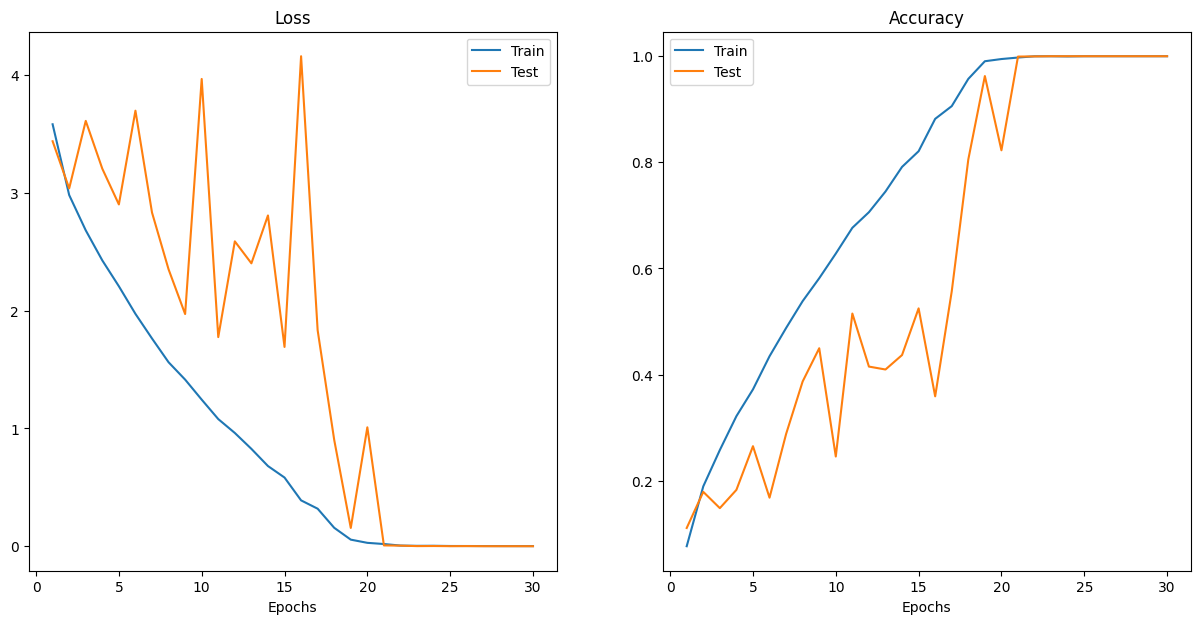

In [144]:
plot_metrics(history=history)

### Loading model

In [145]:
loaded_model = ResNet34()
loaded_model.load_state_dict(torch.load('/kaggle/working/best_model.pt', weights_only=True))
loaded_model.eval()

ResNet34(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (conv_block1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv_block2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
       

In [146]:
#torch.save(model, '/kaggle/working/model.pt')
#load_model = torch.load('/kaggle/working/model.pt')

In [147]:
def show_random_species_predict(original_path: str ) -> None:
  batch = []
  images = []
  species = []

  # Open images and create batch
  for i in range(9):
    specie = random.sample(os.listdir(original_path), k=1)[0]
    species.append(specie)
      
    image_path = random.sample(os.listdir(f'{original_path}/{specie}'), k=1)[0]
    image = Image.open(f'{original_path}/{specie}/{image_path}')
    images.append(image)
      
    # Transform image
    transformed_image = test_transformer(image) 

    batch.append(transformed_image)

      
  # Predict
  batch = torch.stack(batch)
  logits = loaded_model(batch)
  cls = torch.softmax(input=logits, dim=1).argmax(dim=1)

  plt.figure(figsize=(18, 12))    
  for i, (image, specie, clas) in enumerate(zip(images, species, cls)):
    plt.subplot(3, 3, i+1)
      
    plt.title(f"Specie: {specie} \n predict: {test_dataset.classes[clas.item()]}")
    plt.axis(False)
    plt.imshow(image)

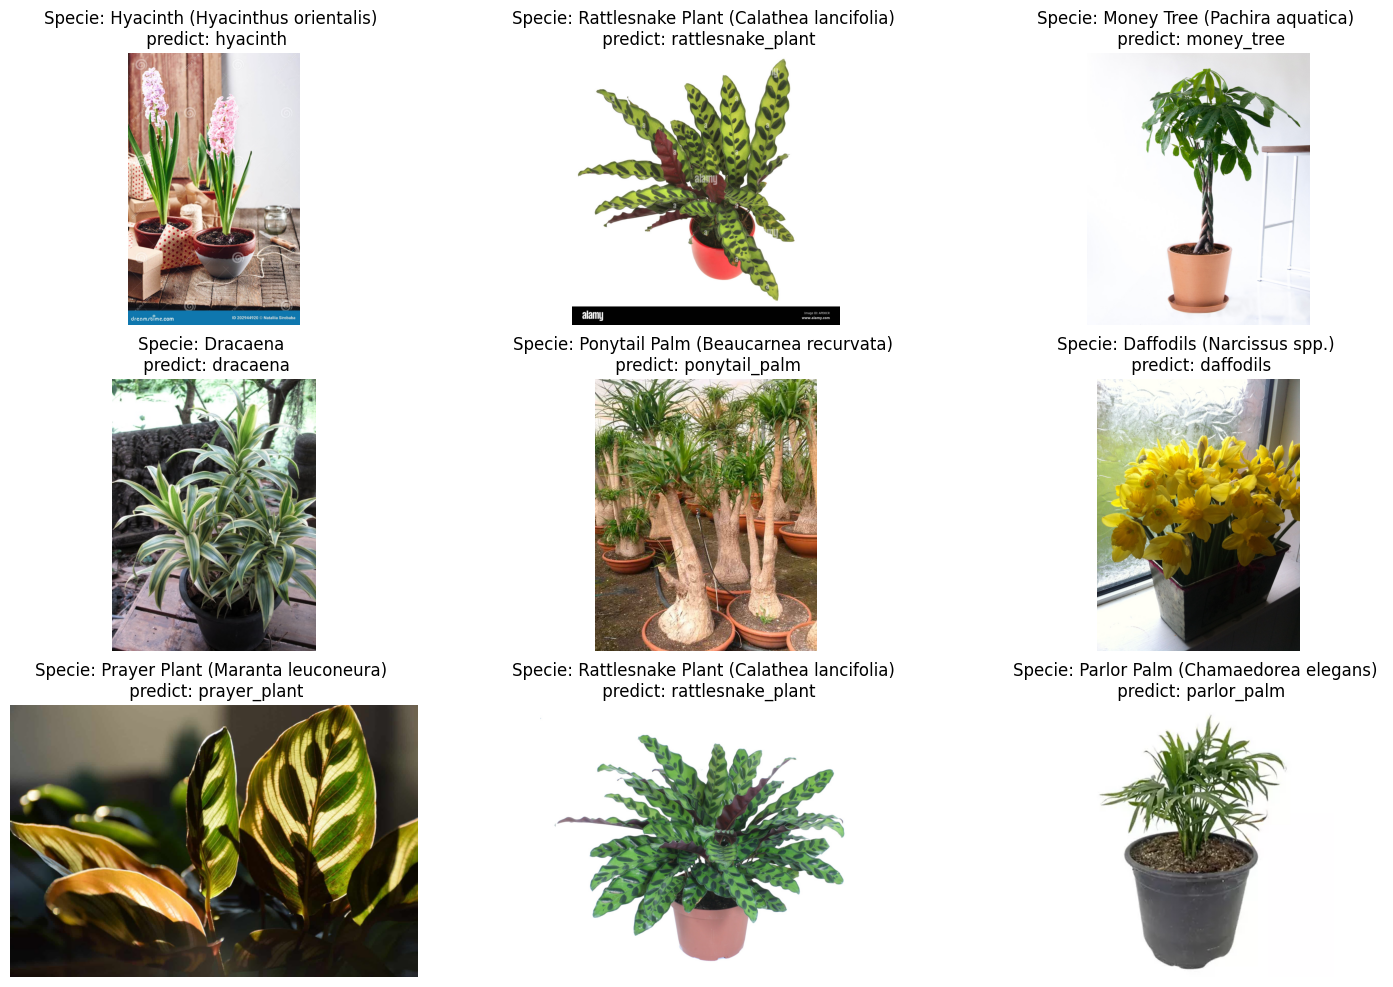

In [148]:
show_random_species_predict(original_path)